This notebook contains simillar information as notebook MFCC-ML in which all the operations were performed on training set. In this notebook, operations will be performed at an evaluation set, which contains more samples. I will also try to introduce manual dataset balancing.

In [5]:
!wget -O training_data.csv https://raw.githubusercontent.com/AndreaSignori/Audio-Spoofing-Detection/refs/heads/main/MFCC_EVAL_FEATURES_LABELED.csv


--2025-02-11 11:08:09--  https://raw.githubusercontent.com/AndreaSignori/Audio-Spoofing-Detection/refs/heads/main/MFCC_EVAL_FEATURES_LABELED.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16770050 (16M) [text/plain]
Saving to: ‘training_data.csv’

training_data.csv   100%[===================>]  15.99M  --.-KB/s    in 0.1s    

2025-02-11 11:08:09 (130 MB/s) - ‘training_data.csv’ saved [16770050/16770050]



In [17]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from itertools import product
from sklearn import linear_model, model_selection, preprocessing, svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    auc,
    average_precision_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling1D,
)
from tensorflow.keras.models import Sequential, load_model
from xgboost import XGBClassifier
from sklearn.metrics import auc
from keras.models import load_model

In [54]:
file_path = "training_data.csv"


eval_df = pd.read_csv(file_path, delimiter=';')

# Drop the first row containing column numbers
eval_df.columns = eval_df.iloc[0]
eval_df = eval_df.drop(eval_df.index[0])

# Drop rows with NaN values
eval_df = eval_df.dropna()

# Drop the 'filename' column
eval_df = eval_df.drop(columns=['filename'])

# Transform 'spoof' to 0 and 'bonafide' to 1 in the 'Label' column
eval_df['Label'] = eval_df['Label'].map({'spoof': 0, 'bonafide': 1})

# Display the cleaned DataFrame
print(eval_df.head())



0  Label      mfcc_1     mfcc_2      mfcc_3     mfcc_4      mfcc_5     mfcc_6  \
1      0    -205.015  139.56729   -46.88559    58.0535  -15.933013  6.7276654   
2      0   -285.1221  113.41989   -8.467953  40.317867   -16.11112  15.670601   
3      0   -232.6206  165.60791  -27.245367   49.38298    -2.76139  0.9697761   
4      0  -301.97018   69.38392  -44.413116  61.301666  -18.442436   -24.4736   
5      0  -317.13718  126.69181   -65.77651  22.715647  -28.936966  -8.015325   

0       mfcc_7      mfcc_8      mfcc_9  ...     mfcc_11     mfcc_12  \
1   -16.274055   -8.880779  -18.400627  ...  -5.2172213   -9.359123   
2    -8.908045   3.4256968  -21.877472  ...   -7.011489  -17.329466   
3  -0.86966246  -22.713154   -11.96604  ...   -9.854653  0.26017064   
4   -13.685907  -19.423687  -21.381638  ...   -8.331615  -2.3441758   
5   -23.152832  -25.740723   -21.53388  ...  -10.727237   -7.691421   

0     mfcc_13     mfcc_14    mfcc_15     mfcc_16     mfcc_17     mfcc_18  \
1   2.1554

<ipython-input-54-cbcd8072b6fc>:4: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  eval_df = pd.read_csv(file_path, delimiter=';')


In [55]:
# Separate features and labels
X = eval_df.drop(columns=["Label"])  # X contains features without columns Label and ID
Y = eval_df["Label"]  # y contains Labels (0 = Spoofed, 1 = Bonafide)

In [56]:
# Check class distribution
class_counts = pd.Series(Y).value_counts()
print("Class Distribution:\n", class_counts)

Class Distribution:
 Label
0    63882
1     7355
Name: count, dtype: int64


Create balanced dataset.

In [57]:
# Create a balanced DataFrame
bonafide_samples = eval_df[eval_df['Label'] == 1]
spoof_samples = eval_df[eval_df['Label'] == 0].sample(n=len(bonafide_samples), random_state=2141831)

balanced_df = pd.concat([bonafide_samples, spoof_samples]).reset_index(drop=True)

# Display the cleaned DataFrame
print(balanced_df.head())

0  Label      mfcc_1     mfcc_2      mfcc_3     mfcc_4      mfcc_5  \
0      1  -402.97076   91.89963  -0.2804517   9.626705   2.1565902   
1      1  -361.59763   98.52667  -10.046808   30.58372   1.0662949   
2      1   -339.0704  71.917534  -15.632757   42.56405  -6.0490546   
3      1   -285.8647  96.458115  -16.327173   35.89828  -12.864523   
4      1  -438.57904   80.79588   1.4521991  28.648617  -3.9705534   

0      mfcc_6       mfcc_7      mfcc_8      mfcc_9  ...     mfcc_11  \
0  0.74882054  -0.84038013  -0.8784534  -6.6335406  ...   -6.147995   
1   3.7170265   -7.6777797  -2.9077327   -5.661212  ...  -7.9528236   
2     4.45085   -11.570544  -2.0293078   -12.01788  ...   -9.456054   
3   1.9376915   -17.821392  -3.0684001  -10.632819  ...  -13.541451   
4   16.799059   -0.3702833    2.352389   -3.333776  ...   1.6654994   

0     mfcc_12     mfcc_13      mfcc_14     mfcc_15      mfcc_16     mfcc_17  \
0  -2.2708023   3.2372456    -4.231891  -2.7242274  -0.21906956  -0.62767

In [58]:
# Separate features and labels
X_bal = balanced_df.drop(columns=["Label"])  # X contains features without columns Label and ID
Y_bal = balanced_df["Label"]  # y contains Labels (0 = Spoofed, 1 = Bonafide)

In [59]:
# Check class distribution
class_counts = pd.Series(Y_bal).value_counts()
print("Class Distribution:\n", class_counts)

Class Distribution:
 Label
1    7355
0    7355
Name: count, dtype: int64


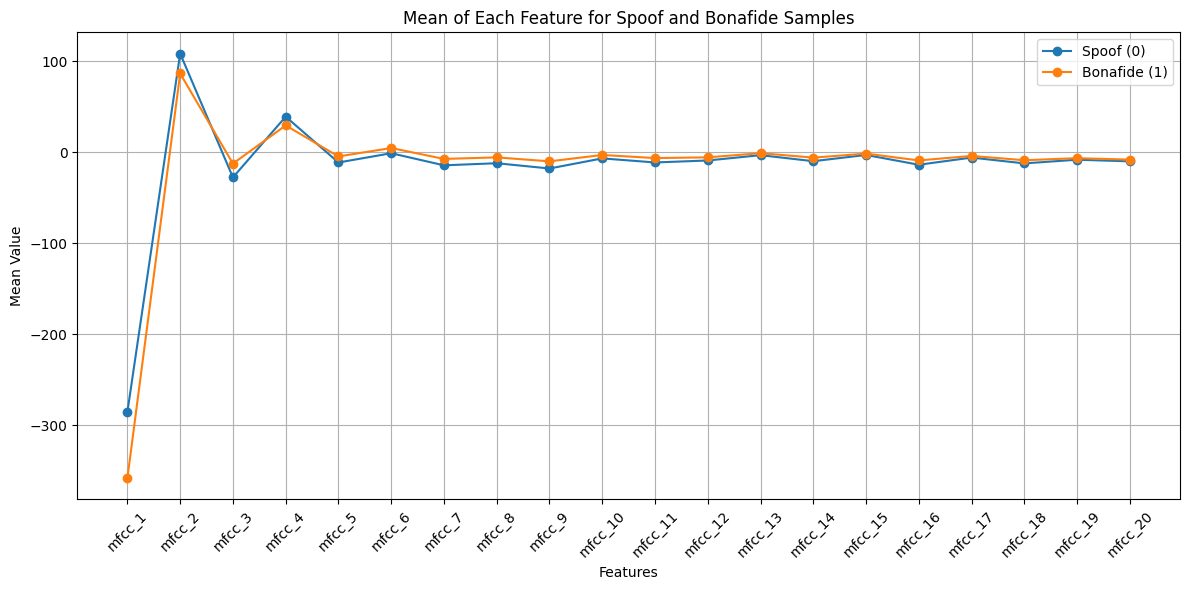

In [60]:
# Convert all feature columns to numeric, forcing errors to NaN
for col in balanced_df.columns:
    if col != "Label":
        balanced_df[col] = pd.to_numeric(balanced_df[col], errors='coerce')

# Calculate mean of each feature for both labels
mean_spoof = balanced_df[balanced_df['Label'] == 0].mean()
mean_bonafide = balanced_df[balanced_df['Label'] == 1].mean()

# Plot the means
plt.figure(figsize=(12, 6))
plt.plot(mean_spoof.index[1:], mean_spoof.values[1:], label='Spoof (0)', marker='o')
plt.plot(mean_bonafide.index[1:], mean_bonafide.values[1:], label='Bonafide (1)', marker='o')

plt.xlabel('Features')
plt.ylabel('Mean Value')
plt.title('Mean of Each Feature for Spoof and Bonafide Samples')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [61]:
X_train, X_test, Y_train, Y_test = train_test_split(X_bal, Y_bal, test_size = 0.2, random_state = 2141831)

print("Training size (Original):", X_train.shape[0])
print("Test size (Original):", X_test.shape[0])

Training size (Original): 11768
Test size (Original): 2942


In [62]:
clf = DecisionTreeClassifier(random_state=214831)
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
roc_score = roc_auc_score(Y_test, Y_pred)

report = classification_report(Y_test, Y_pred)
print("Classification Report: \n", report)

Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.84      0.83      1455
           1       0.84      0.83      0.84      1487

    accuracy                           0.83      2942
   macro avg       0.83      0.83      0.83      2942
weighted avg       0.83      0.83      0.83      2942



In [63]:
rf = RandomForestClassifier(n_estimators=200, max_depth=100, random_state=2141831)
rf.fit(X_train, Y_train)

Y_pred = rf.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)
class_report = classification_report(Y_test, Y_pred)

# Print evaluation metrics
print(f"Model Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Model Accuracy: 0.9079

Confusion Matrix:
 [[1273  182]
 [  89 1398]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.87      0.90      1455
           1       0.88      0.94      0.91      1487

    accuracy                           0.91      2942
   macro avg       0.91      0.91      0.91      2942
weighted avg       0.91      0.91      0.91      2942



In [64]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size = 0.2, random_state = 2141831)


In [65]:
# Train XGBoost Classifier
xgb_model = XGBClassifier(
    n_estimators=100,  # Number of trees
    max_depth=6,  # Depth of each tree
    learning_rate=0.1,  # Step size shrinkage
    subsample=0.8,  # Percentage of samples used per tree
    colsample_bytree=0.8,  # Percentage of features used per tree
    random_state=2141831
)

xgb_model.fit(X_train, Y_train)

# Predictions on test set
Y_pred_xgb = xgb_model.predict(X_test)

# Evaluate model performance
accuracy_xgb = accuracy_score(Y_test, Y_pred_xgb)
conf_matrix_xgb = confusion_matrix(Y_test, Y_pred_xgb)
class_report_xgb = classification_report(Y_test, Y_pred_xgb)

# Print model evaluation results
print(f"\nXGBoost Model Accuracy: {accuracy_xgb:.4f}")
print("\nConfusion Matrix:\n", conf_matrix_xgb)
print("\nClassification Report:\n", class_report_xgb)


XGBoost Model Accuracy: 0.9539

Confusion Matrix:
 [[12614   143]
 [  514   977]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97     12757
           1       0.87      0.66      0.75      1491

    accuracy                           0.95     14248
   macro avg       0.92      0.82      0.86     14248
weighted avg       0.95      0.95      0.95     14248



<ipython-input-66-aed25f8707d8>:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  all_leading_digits_label_0 = label_0_data[mfcc_columns].applymap(first_non_zero_leading_digit).values.flatten()
<ipython-input-66-aed25f8707d8>:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  all_leading_digits_label_1 = label_1_data[mfcc_columns].applymap(first_non_zero_leading_digit).values.flatten()


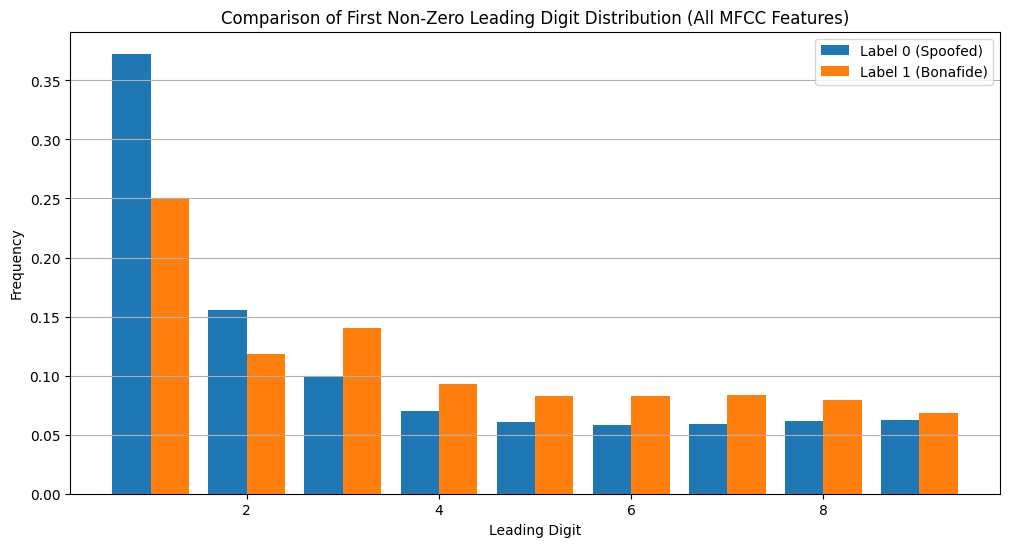

In [66]:
# Function to extract the first non-zero leading digit from a number
def first_non_zero_leading_digit(x):
    x = abs(float(x))
    if x == 0:
        return 0
    while x < 1:
        x *= 10
    return int(str(int(x)).lstrip('0')[0]) if str(int(x)).lstrip('0') else 0

# Select MFCC columns
mfcc_columns = [col for col in eval_df.columns if col.startswith('mfcc_')]

# Filter data for label 0 and label 1
label_0_data = eval_df[eval_df['Label'] == 0]
label_1_data = eval_df[eval_df['Label'] == 1]

# Combine all MFCC features into one series of leading digits
all_leading_digits_label_0 = label_0_data[mfcc_columns].applymap(first_non_zero_leading_digit).values.flatten()
all_leading_digits_label_1 = label_1_data[mfcc_columns].applymap(first_non_zero_leading_digit).values.flatten()

# Calculate frequency distribution of leading digits
combined_leading_digit_stats_label_0 = pd.Series(all_leading_digits_label_0).value_counts(normalize=True).sort_index()
combined_leading_digit_stats_label_1 = pd.Series(all_leading_digits_label_1).value_counts(normalize=True).sort_index()

# Plotting the combined leading digit statistics for both labels
plt.figure(figsize=(12, 6))
plt.bar(combined_leading_digit_stats_label_0.index - 0.2, combined_leading_digit_stats_label_0.values, width=0.4, label='Label 0 (Spoofed)')
plt.bar(combined_leading_digit_stats_label_1.index + 0.2, combined_leading_digit_stats_label_1.values, width=0.4, label='Label 1 (Bonafide)')

plt.title('Comparison of First Non-Zero Leading Digit Distribution (All MFCC Features)')
plt.xlabel('Leading Digit')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y')
plt.show()


In [67]:
# Train SVM Classifier with RBF kernel
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=2141831)
svm_model.fit(X_train, Y_train)

# Predictions on test set
Y_pred_svm = svm_model.predict(X_test)

# Evaluate model performance
accuracy_svm = accuracy_score(Y_test, Y_pred_svm)
conf_matrix_svm = confusion_matrix(Y_test, Y_pred_svm)
class_report_svm = classification_report(Y_test, Y_pred_svm)

# Print model evaluation results
print(f"\nSVM Model Accuracy: {accuracy_svm:.4f}")
print("\nConfusion Matrix:\n", conf_matrix_svm)
print("\nClassification Report:\n", class_report_svm)


SVM Model Accuracy: 0.9613

Confusion Matrix:
 [[12615   142]
 [  410  1081]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     12757
           1       0.88      0.73      0.80      1491

    accuracy                           0.96     14248
   macro avg       0.93      0.86      0.89     14248
weighted avg       0.96      0.96      0.96     14248



In this section, we load and preprocess the evaluation dataset for audio deepfake detection. Below is a detailed breakdown of the steps involved:

Loading the Dataset:
* We begin by reading the training_data.csv file using pandas.read_csv(). The file contains data for audio samples, including their features and corresponding labels that indicate whether the audio is a genuine (bonafide) recording or a spoofed (deepfake) sample.
* Dropping the First Row and Missing Values:
After loading the dataset, we notice that the first row contains column names but is mistakenly included as a regular data row. We fix this by assigning the first row as column headers using eval_df.columns = eval_df.iloc[0] and then dropping it using drop(). Additionally, we remove any rows with missing values using dropna().
* Removing Unnecessary Columns:
The dataset includes a filename column that holds the names of audio files. Since it does not contribute to model training or evaluation, we drop it using drop(columns=['filename']).
* Mapping Labels for Model Compatibility:
The target variable in the dataset is Label, which can have two values: 'spoof' (deepfake) or 'bonafide' (genuine). We map these string values to numerical representations: 0 for 'spoof' and 1 for 'bonafide', using map().

In [5]:
# Load and preprocess evaluation dataset
file_path = "training_data.csv"
eval_df = pd.read_csv(file_path, delimiter=';')

# Drop the first row containing column names and NaN values
eval_df.columns = eval_df.iloc[0]
eval_df = eval_df.drop(eval_df.index[0])
eval_df = eval_df.dropna()

# Drop the 'filename' column and map labels
eval_df = eval_df.drop(columns=['filename'])
eval_df['Label'] = eval_df['Label'].map({'spoof': 0, 'bonafide': 1})


<ipython-input-5-9f7427ba134a>:3: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  eval_df = pd.read_csv(file_path, delimiter=';')


To ensure that the model performs equally well on both bonafide and spoof audio samples, we need to balance the dataset. An imbalanced dataset, where one class significantly outnumbers the other, can lead to biased model predictions. The following steps describe how we address this issue:

We first isolate the bonafide and spoof samples from the evaluation dataset.
Since the dataset typically contains more bonafide or spoof samples, we balance it by randomly sampling an equal number of spoof samples to match the number of bonafide samples. This random sampling ensures that our dataset has an equal distribution of classes for training and evaluation:

* sample(n=len(bonafide_samples), random_state=2141831): Randomly selects a subset of spoof samples equal in size to the number of bonafide samples. We use a fixed random_state to ensure reproducibility. <br>
* pd.concat([bonafide_samples, spoof_samples]): Combines the bonafide and spoof samples into a single balanced dataset.<br>
* reset_index(drop=True): Resets the DataFrame index to ensure consistent indexing after combining the samples.

After balancing the dataset, we separate the features and labels for model training.
The features are all columns except Label, which is the target variable. We drop this column using drop(columns=["Label"]) to create the feature matrix X.
The labels (target values) are stored in Y using balanced_df["Label"].values.

In [6]:
# Balance the dataset
bonafide_samples = eval_df[eval_df['Label'] == 1]
spoof_samples = eval_df[eval_df['Label'] == 0].sample(n=len(bonafide_samples), random_state=2141831)
balanced_df = pd.concat([bonafide_samples, spoof_samples]).reset_index(drop=True)

# Separate features and labels
X = balanced_df.drop(columns=["Label"]).values
Y = balanced_df["Label"].values

This reshaping is essential because CNNs are designed to process structured input with dimensions corresponding to spatial or temporal patterns. By transforming the feature data into this shape, we ensure compatibility with CNN architecture.

In [7]:
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape X for CNN (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)


To evaluate the performance of the deep learning model effectively, we need to divide the dataset into training and testing sets.



In [8]:

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

The Convolutional Neural Network (CNN) architecture is designed to capture meaningful features from audio data to distinguish between bonafide and spoof audio samples <br>
* We use the Sequential API from Keras to define the model as a linear stack of layers. <br>

* Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)):
Applies 1D convolution with 32 filters and a kernel size of 3. The ReLU activation function introduces non-linearity, and the input shape is defined by the feature length (X_train.shape[1]) and one input channel.<br>
* BatchNormalization(): Normalizes the activations to stabilize and accelerate training.<br>
* MaxPooling1D(pool_size=2): Downsamples the feature map by taking the maximum value over a window of size 2 to reduce computation and extract dominant features.<br>
* Dropout(0.3): Randomly sets 30% of the neurons to zero during training to prevent overfitting. <br>
* We then create another blockwith similar structure as the first one but with 64 filters to capture more complex patterns. <br>
* Dense(128, activation='relu'): Applies a dense (fully connected) layer with 128 units and ReLU activation.
* Dropout(0.4): Applies a 40% dropout to further reduce overfitting.
* Then for the Output layer we have a single neuron with a sigmoid activation function, suitable for binary classification. The output will be a probability value between 0 and 1, where values close to 0 indicate spoof audio, and values near 1 indicate bonafide audio.

In [10]:

# Build CNN Model (more complex architecture)
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=1),
    Dropout(0.2),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(filters=256, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Flatten(),
    Dense(512, activation='relu'),  # Increased Dense layer size
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


After defining the CNN architecture, we compile and train the model to learn from the training data and evaluate its performance on unseen data<br>
* The Adam optimizer is a popular choice for deep learning tasks because it combines the advantages of both RMSProp and Stochastic Gradient Descent (SGD) optimizers. It adapts the learning rate during training for better convergence.
* Binary cross-entropy is used because this is a binary classification problem (spoof vs. bonafide). It measures the difference between the predicted and true probabilities.
* accuracy: Tracks the proportion of correctly predicted samples.
* AUC (Area Under the Curve): Measures the model's ability to distinguish between the two classes. A higher AUC indicates better model performance.

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# Train the model (with early stopping and ReduceLROnPlateau)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
history = model.fit(X_train, Y_train, epochs=50,  # Increased epochs
                    batch_size=64,  # Increased batch size
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stopping, reduce_lr])  # Added callbacks

Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.7783 - auc: 0.8604 - loss: 0.4858 - val_accuracy: 0.8131 - val_auc: 0.8938 - val_loss: 0.5752 - learning_rate: 1.0000e-04
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8549 - auc: 0.9293 - loss: 0.3314 - val_accuracy: 0.7923 - val_auc: 0.8986 - val_loss: 0.4409 - learning_rate: 1.0000e-04
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8672 - auc: 0.9373 - loss: 0.3154 - val_accuracy: 0.8895 - val_auc: 0.9547 - val_loss: 0.2828 - learning_rate: 1.0000e-04
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8940 - auc: 0.9563 - loss: 0.2630 - val_accuracy: 0.9099 - val_auc: 0.9664 - val_loss: 0.2313 - learning_rate: 1.0000e-04
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8886 - auc: 0.9528 - loss: 0.2733 - val_accuracy: 0.9108 - val_auc: 0.9696 - val_loss: 0.2196 - learning_rate: 1.0000e-04
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accu

After training the CNN, we need to assess its performance on the test dataset, which contains samples that the model has never seen during training.

In [12]:
# Evaluate the model
loss, accuracy, auc = model.evaluate(X_test, Y_test, verbose=1)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}, Test AUC: {auc:.4f}")


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9391 - auc: 0.9850 - loss: 0.1528
Test Loss: 0.1543, Test Accuracy: 0.9412, Test AUC: 0.9847


To analyze the performance of the CNN during training, it is essential to visualize how the accuracy and loss evolved over epochs for both the training and validation sets.

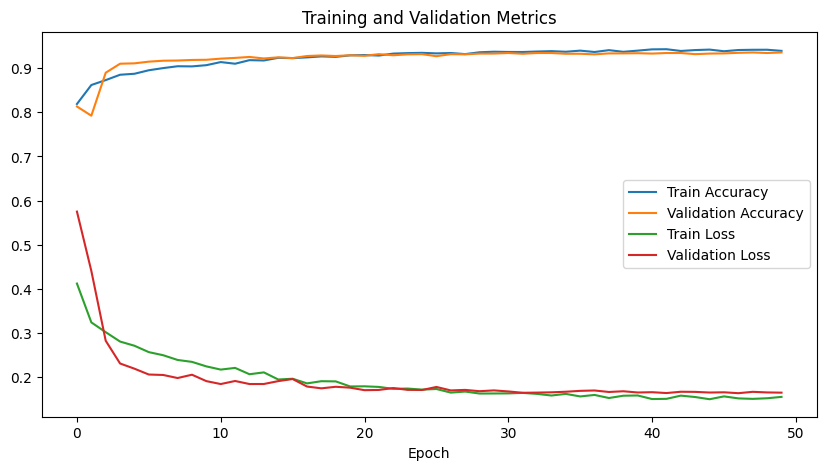

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


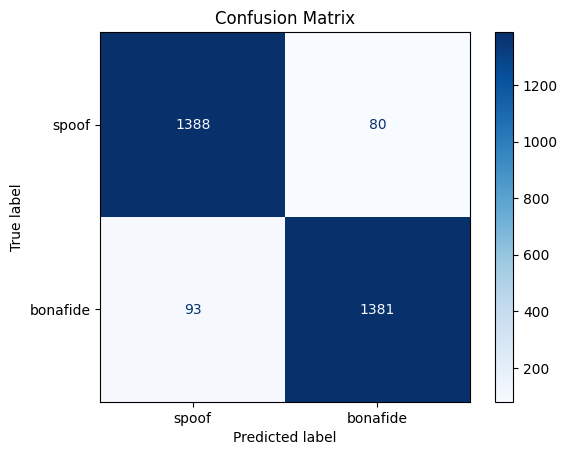

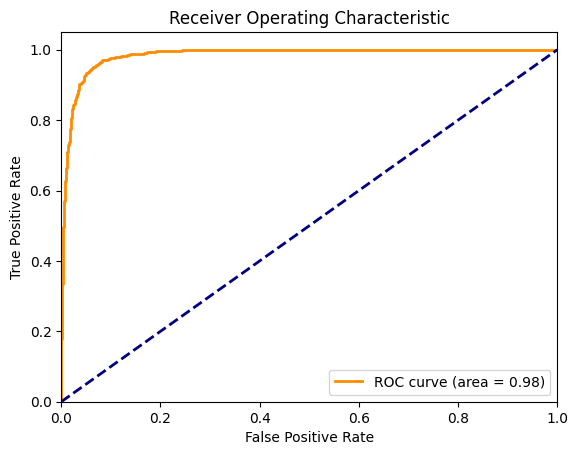

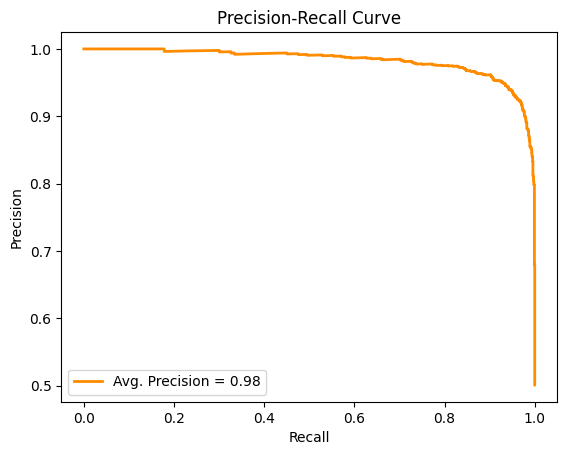

Classification Report:
              precision    recall  f1-score   support

       spoof       0.94      0.95      0.94      1468
    bonafide       0.95      0.94      0.94      1474

    accuracy                           0.94      2942
   macro avg       0.94      0.94      0.94      2942
weighted avg       0.94      0.94      0.94      2942



In [14]:

# Plot training and validation metrics (combined plot)
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Confusion Matrix
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to classes
cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['spoof', 'bonafide'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(Y_test, y_pred_probs)
roc_auc = roc_auc_score(Y_test, y_pred_probs)  # Use roc_auc_score
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(Y_test, y_pred_probs)
avg_precision = average_precision_score(Y_test, y_pred_probs)
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='Avg. Precision = %0.2f' % avg_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(Y_test, y_pred, target_names=['spoof', 'bonafide']))

# Save the model
model.save("our_audio_classifier.h5")

The graphs above illustrate the training performance of our machine learning model over 40 epochs. Let's break down the key trends:<br>

Accuracy
Training Accuracy: Demonstrates a consistent upward trend, indicating the model's increasing ability to correctly classify training data.
Validation Accuracy: Closely mirrors the training accuracy, suggesting the model generalizes well to unseen data and isn't overfitting.
Loss

Training Loss: Exhibits a steady decline, signifying the model's reduction in prediction errors on the training set.<br>
Validation Loss: Also shows a decreasing trend, reinforcing the model's ability to generalize and make accurate predictions on new data.

The model exhibits healthy convergence with both accuracy and loss metrics improving steadily over epochs. This indicates effective learning and generalization.